In [1]:
import os
import random
os.environ["CUDA_VISIBLE_DEVICES"] = '0'
import numpy as np
import pandas as pd
import cv2
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import shapely
from shapely.geometry import Polygon, MultiPoint  # 多边形
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

import torchvision.models as tvmodel
import torch.nn as nn
import torch

# def convert(size, box):
#     shaoling's code
#     """将bbox的左上角点、右下角点坐标的格式，转换为bbox中心点+bbox的w,h的格式
#     并进行归一化"""
#     dw = 1. / size[0]
#     dh = 1. / size[1]
#     x = ((box[0, 0] + box[0, 1] + box[0, 2] + box[0, 3]) * 10 + 400) / 4.0
#     y = ((box[1, 0] + box[1, 1] + box[1, 2] + box[1, 3]) * 10 + 400) / 4.0
#     w = np.sqrt((box[0, 1] * 10 - box[0, 2] * 10)**2 + (box[1, 1] * 10 - box[1, 2] * 10)**2)
#     h = np.sqrt((box[0, 0] * 10 - box[0, 1] * 10)**2 + (box[1, 0] * 10 - box[1, 1] * 10)**2)
#     #x = (box[1,1]*10 + box[1,0]*10) / 2.0
#     #y = (box[0,1]*10 + box[0,2]*10) / 2.0
#     # w = abs(box[1,1]*10 - box[1,0]*10)
#     # h = abs(box[0,2]*10 - box[0,1]*10)
#     x = x * dw
#     w = w * dw
#     y = y * dh
#     h = h * dh
#     th = (box[1, 0] + box[1, 1] - box[1, 2] - box[1, 3]) / (box[0, 0] + box[0, 1] - box[0, 2] - box[0, 3])
#     theta = np.arctan(th)
#     #print(theta)
#     return (x, y, w, h, theta)

def convert(size, box):
    """将bbox的左上角点、右下角点坐标的格式，转换为bbox中心点+bbox的w,h的格式
    并进行归一化"""
    dw = 1. / size[0]
    dh = 1. / size[1]
    if abs(box[0, 0] - box[0, 2]) > abs(box[0, 0] - box[0, 1]):
        box[0,0], box[0,1], box[0,2], box[0,3] = box[0,1], box[0, 3], box[0,0], box[0,2]
        box[1,0], box[1,1], box[1,2], box[1,3] = box[1,1], box[1, 3], box[1,0], box[1,2]
    x = ((box[0, 0] + box[0, 1] + box[0, 2] + box[0, 3]) * 10) / 4.0
    y = ((box[1, 0] + box[1, 1] + box[1, 2] + box[1, 3]) * 10) / 4.0
    h = np.sqrt((box[0, 0] * 10 - box[0, 2] * 10)**2 + (box[1, 0] * 10 - box[1, 2] * 10)**2)
    w = np.sqrt((box[0, 0] * 10 - box[0, 1] * 10)**2 + (box[1, 1] * 10 - box[1, 0] * 10)**2)
    x = x * dw + 0.5
    w = w * dw
    y = y * dh + 0.5
    h = h * dh
    th = (box[1, 1] - box[1, 0]) / (box[0, 1] - box[0, 0])
    theta = np.arctan(th)
    return (x, y, w, h, theta)


NUM_BBOX = 2
CLASSES = ['other_vehicle', 'bicycle','car', 'pedestrian', 'truck', 'bus', 'motorcycle', 'emergency_vehicle', 'animal']
def convert_bbox2labels(bbox):
    """将bbox的(cls,x,y,w,h, theta)数据转换为训练时方便计算Loss的数据形式(7,7,6*B+cls_num)
    注意，输入的bbox的信息是(xc,yc,w,h, theta)格式的，转换为labels后，bbox的信息转换为了(px,py,w,h)格式"""
    gridsize = 1.0/7
    labels = np.zeros((7,7,6*NUM_BBOX+len(CLASSES)))  # 注意，此处需要根据不同数据集的类别个数进行修改
    for i in range(len(bbox)//6):
        gridx = int(bbox[i*6+1] // gridsize)  # 当前bbox中心落在第gridx个网格,列
        gridy = int(bbox[i*6+2] // gridsize)  # 当前bbox中心落在第gridy个网格,行
        # (bbox中心坐标 - 网格左上角点的坐标)/网格大小  ==> bbox中心点的相对位置
        gridpx = bbox[i * 6 + 1] / gridsize - gridx
        gridpy = bbox[i * 6 + 2] / gridsize - gridy
        # 将第gridy行，gridx列的网格设置为负责当前ground truth的预测，置信度和对应类别概率均置为1
        labels[gridy, gridx, 0:6] = np.array([gridpx, gridpy, bbox[i * 6 + 3], bbox[i * 6 + 4], bbox[i * 6 + 5], 1])
        labels[gridy, gridx, 6:12] = np.array([gridpx, gridpy, bbox[i * 6 + 3], bbox[i * 6 + 4], bbox[i * 6 + 5], 1])
        labels[gridy, gridx, 12+int(bbox[i*6])] = 1
    return labels

class Loss_yolov1(nn.Module):
    def __init__(self):
        super(Loss_yolov1,self).__init__()

    def forward(self, pred, labels):
        """
        :param pred: (batchsize,30,7,7)的网络输出数据
        :param labels: (batchsize,30,7,7)的样本标签数据
        :return: 当前批次样本的平均损失
        """
        num_gridx, num_gridy = labels.size()[-2:]  # 划分网格数量
        num_b = 2  # 每个网格的bbox数量
        num_cls = 9  # 类别数量
        noobj_confi_loss = 0.  # 不含目标的网格损失(只有置信度损失)
        coor_loss = 0.  # 含有目标的bbox的坐标损失
        obj_confi_loss = 0.  # 含有目标的bbox的置信度损失
        class_loss = 0.  # 含有目标的网格的类别损失
        n = labels.size()[0]  # batchsize的大小

        # 可以考虑用矩阵运算进行优化，提高速度，为了准确起见，这里还是用循环
        for i in range(n):  # batchsize循环
            for m in range(7):  # x方向网格循环
                for n in range(7):  # y方向网格循环
                    if labels[i,5,m,n]==1:# 如果包含物体
                        # 将数据(px,py,w,h)转换为(x1,y1,x2,y2)
                        # 先将px,py转换为cx,cy，即相对网格的位置转换为标准化后实际的bbox中心位置cx,xy
                        # 然后再利用(cx-w/2,cy-h/2,cx+w/2,cy+h/2)转换为xyxy形式，用于计算iou
                        bbox1_pred_xyxy = ((pred[i,0,m,n]+m)/num_gridx - pred[i,2,m,n]/2,(pred[i,1,m,n]+n)/num_gridy - pred[i,3,m,n]/2,
                                           (pred[i,0,m,n]+m)/num_gridx + pred[i,2,m,n]/2,(pred[i,1,m,n]+n)/num_gridy + pred[i,3,m,n]/2)
                        bbox2_pred_xyxy = ((pred[i,6,m,n]+m)/num_gridx - pred[i,8,m,n]/2,(pred[i,7,m,n]+n)/num_gridy - pred[i,9,m,n]/2,
                                           (pred[i,6,m,n]+m)/num_gridx + pred[i,8,m,n]/2,(pred[i,7,m,n]+n)/num_gridy + pred[i,9,m,n]/2)
                        bbox_gt_xyxy = ((labels[i,0,m,n]+m)/num_gridx - labels[i,2,m,n]/2,(labels[i,1,m,n]+n)/num_gridy - labels[i,3,m,n]/2,
                                        (labels[i,0,m,n]+m)/num_gridx + labels[i,2,m,n]/2,(labels[i,1,m,n]+n)/num_gridy + labels[i,3,m,n]/2)
                        iou1 = skewiou(bbox1_pred_xyxy,bbox_gt_xyxy, pred[i,4,m,n],labels[i,4,m,n])
                        iou2 = skewiou(bbox2_pred_xyxy,bbox_gt_xyxy, pred[i,10,m,n], labels[i,4,m,n])
                        # 选择iou大的bbox作为负责物体
                        if iou1 >= iou2:
                            coor_loss = coor_loss + 5 * (torch.sum((pred[i,0:2,m,n] - labels[i,0:2,m,n])**2) \
                                        + torch.sum((pred[i,2:4,m,n].sqrt()-labels[i,2:4,m,n].sqrt())**2)) \
                                        + (pred[i,4,m,n]-labels[i,4,m,n])**2
                            obj_confi_loss = obj_confi_loss + (pred[i,5,m,n] - iou1)**2
                            # iou比较小的bbox不负责预测物体，因此confidence loss算在noobj中，注意，对于标签的置信度应该是iou2
                            noobj_confi_loss = noobj_confi_loss + 0.5 * ((pred[i,11,m,n]-iou2)**2)
                        else:
                            coor_loss = coor_loss + 5 * (torch.sum((pred[i,6:8,m,n] - labels[i,6:8,m,n])**2) \
                                        + torch.sum((pred[i,8:10,m,n].sqrt()-labels[i,8:10,m,n].sqrt())**2)) \
                                        + (pred[i,10,m,n]-labels[i,10,m,n])**2
                            obj_confi_loss = obj_confi_loss + (pred[i,11,m,n] - iou2)**2
                            # iou比较小的bbox不负责预测物体，因此confidence loss算在noobj中,注意，对于标签的置信度应该是iou1
                            noobj_confi_loss = noobj_confi_loss + 0.5 * ((pred[i, 5, m, n]-iou1) ** 2)
                        class_loss = class_loss + torch.sum((pred[i,12:,m,n] - labels[i,12:,m,n])**2)
                    else:  # 如果不包含物体
                        noobj_confi_loss = noobj_confi_loss + 0.5 * torch.sum(pred[i,[5,11],m,n]**2)

        loss = coor_loss + obj_confi_loss + noobj_confi_loss + class_loss
        # 此处可以写代码验证一下loss的大致计算是否正确，这个要验证起来比较麻烦，比较简洁的办法是，将输入的pred置为全1矩阵，再进行误差检查，会直观很多。
        return loss/n

def calculate_iou(bbox1,bbox2):
    """计算bbox1=(x1,y1,x2,y2)和bbox2=(x3,y3,x4,y4)两个bbox的iou"""
    intersect_bbox = [0., 0., 0., 0.]  # bbox1和bbox2的交集
    if bbox1[2]<bbox2[0] or bbox1[0]>bbox2[2] or bbox1[3]<bbox2[1] or bbox1[1]>bbox2[3]:
        pass
    else:
        intersect_bbox[0] = max(bbox1[0],bbox2[0])
        intersect_bbox[1] = max(bbox1[1],bbox2[1])
        intersect_bbox[2] = min(bbox1[2],bbox2[2])
        intersect_bbox[3] = min(bbox1[3],bbox2[3])

    area1 = (bbox1[2] - bbox1[0]) * (bbox1[3] - bbox1[1])  # bbox1面积
    area2 = (bbox2[2] - bbox2[0]) * (bbox2[3] - bbox2[1])  # bbox2面积
    area_intersect = (intersect_bbox[2] - intersect_bbox[0]) * (intersect_bbox[3] - intersect_bbox[1])  # 交集面积
    # print(bbox1,bbox2)
    # print(intersect_bbox)
    # input()

    if area_intersect>0:
        return area_intersect / (area1 + area2 - area_intersect)  # 计算iou
    else:
        return 0

def skewiou(box1, box2, theta1, theta2):
    box1 = np.asarray(box1)
    box2 = np.asarray(box2)
    box1 = rotate_box(box1, theta1, (box1[0]+box1[2])/2, (box1[1]+box1[3])/2)
    box2 = rotate_box(box2, theta2, (box2[0]+box2[2])/2, (box2[1]+box2[3])/2)
    #[x1, y1, x2, y2, x3, y3, x4, y4]
    a = np.array(box1).reshape(4, 2)
    b = np.array(box2).reshape(4, 2)
    # 所有点的最小凸的表示形式，四边形对象，会自动计算四个点，最后顺序为：左上 左下  右下 右上 左上
    poly1 = Polygon(a).convex_hull
    poly2 = Polygon(b).convex_hull

    # 异常情况排除
    if not poly1.is_valid or not poly2.is_valid:
        print('formatting errors for boxes!!!! ')
        return 0
    if poly1.area == 0 or poly2.area == 0:
        return 0

    inter = Polygon(poly1).intersection(Polygon(poly2)).area
    union = poly1.area + poly2.area - inter

    if union == 0:
        return 0
    else:
        return inter / union


def rotate_box(corners, angle, cx, cy):
    # [x1, y1, x2, y2]
    corners = np.array([[corners[0], corners[1]],
                        [corners[2],corners[1]],
                        [corners[2],corners[3]],
                        [corners[0],corners[3]]])
    corners = corners.reshape(-1, 2)
    corners = np.hstack((corners, np.ones((corners.shape[0], 1), dtype=type(corners[0][0]))))

    M = cv2.getRotationMatrix2D((cx, cy), angle*180/np.pi, 1.0)

    calculated = np.dot(M, corners.T).T
    calculated = calculated.reshape(-1, 8)

    return calculated


class YOLOv1_resnet(nn.Module):
    def __init__(self):
        super(YOLOv1_resnet, self).__init__()
        resnet = tvmodel.resnet18(pretrained=True)  # 调用torchvision里的resnet34预训练模型
        resnet_out_channel = resnet.fc.in_features  # 记录resnet全连接层之前的网络输出通道数，方便连入后续卷积网络中
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])  # 去除resnet的最后两层
        # 以下是YOLOv1的最后四个卷积层
        self.Conv_layers = nn.Sequential(
            nn.Conv2d(resnet_out_channel, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),  # 为了加快训练，这里增加了BN层，原论文里YOLOv1是没有的
            nn.LeakyReLU(),
            nn.Conv2d(1024, 1024, 3, stride=2, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
            nn.Conv2d(1024, 1024, 3, padding=1),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
        )
        # 以下是YOLOv1的最后2个全连接层
        self.Conn_layers1 = nn.Sequential(
            nn.Linear(4 * 4 * 1024, 4096),
            nn.LeakyReLU())
        self.Conn_layers2 = nn.Sequential(
            nn.Linear(4096 * 6, 4096),
            nn.LeakyReLU(),
            nn.Linear(4096, 7 * 7 * (6 * NUM_BBOX + len(CLASSES))),
            nn.Sigmoid())

    def forward(self, input):
        x1 = self.resnet(input[:, 0])
        x1 = self.Conv_layers(x1)
        x1 = x1.view(x1.size()[0], -1)
        x1 = self.Conn_layers1(x1)

        x2 = self.resnet(input[:, 1])
        x2 = self.Conv_layers(x2)
        x2 = x2.view(x2.size()[0], -1)
        x2 = self.Conn_layers1(x2)
        x3 = self.resnet(input[:, 2])
        x3 = self.Conv_layers(x3)
        x3 = x3.view(x3.size()[0], -1)
        x3 = self.Conn_layers1(x3)

        x4 = self.resnet(input[:, 3])
        x4 = self.Conv_layers(x4)
        x4 = x4.view(x4.size()[0], -1)
        x4 = self.Conn_layers1(x4)

        x5 = self.resnet(input[:, 4])
        x5 = self.Conv_layers(x5)
        x5 = x5.view(x5.size()[0], -1)
        x5 = self.Conn_layers1(x5)

        x6 = self.resnet(input[:, 5])
        x6 = self.Conv_layers(x6)
        x6 = x6.view(x6.size()[0], -1)
        x6 = self.Conn_layers1(x6)

        x = torch.cat([x1, x2, x3, x4, x5, x6], dim=1)
        x = self.Conn_layers2(x)

        return x.reshape(-1, (6 * NUM_BBOX + len(CLASSES)), 7, 7)


    

In [2]:
import os
import random

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

def labels2bbox(matrix):
    """
    将网络输出的7*7*30的数据转换为bbox的(98,25)的格式，然后再将NMS处理后的结果返回
    :param matrix: 注意，输入的数据中，bbox坐标的格式是(px,py,w,h)，需要转换为(x1,y1,x2,y2)的格式再输入NMS
    :return: 返回NMS处理后的结果
    """
    if matrix.size()[0:2]!=(7,7):
        raise ValueError("Error: Wrong labels size:",matrix.size())
    bbox = torch.zeros((98,15))
    # 先把7*7*30的数据转变为bbox的(98,25)的格式，其中，bbox信息格式从(px,py,w,h)转换为(x1,y1,x2,y2),方便计算iou
    for i in range(7):  # i是网格的行方向(y方向)
        for j in range(7):  # j是网格的列方向(x方向)
            bbox[2*(i*7+j),0:4] = torch.Tensor([(matrix[i, j, 0] + j) / 7 - matrix[i, j, 2] / 2,
                                                (matrix[i, j, 1] + i) / 7 - matrix[i, j, 3] / 2,
                                                (matrix[i, j, 0] + j) / 7 + matrix[i, j, 2] / 2,
                                                (matrix[i, j, 1] + i) / 7 + matrix[i, j, 3] / 2])
            bbox[2 * (i * 7 + j), 4] = matrix[i,j,4]
            bbox[2 * (i * 7 + j), 5] = matrix[i,j,5]
            bbox[2*(i*7+j),6:] = matrix[i,j,12:]
    
            bbox[2*(i*7+j)+1,0:4] = torch.Tensor([(matrix[i, j, 6] + j) / 7 - matrix[i, j, 8] / 2,
                                                (matrix[i, j, 7] + i) / 7 - matrix[i, j, 9] / 2,
                                                (matrix[i, j, 6] + j) / 7 + matrix[i, j, 8] / 2,
                                                (matrix[i, j, 7] + i) / 7 + matrix[i, j, 9] / 2])
            bbox[2 * (i * 7 + j)+1, 4] = matrix[i, j, 10]
            bbox[2 * (i * 7 + j)+1, 5] = matrix[i, j, 11]
            bbox[2*(i*7+j)+1,6:] = matrix[i,j,12:]
    #return bbox
    #print(bbox.shape)
    return NMS(bbox)  # 对所有98个bbox执行NMS算法，清理cls-specific confidence score较低以及iou重合度过高的bbox
def NMS(bbox, conf_thresh=0.03, iou_thresh=0.5):
    """bbox数据格式是(n,15),前5个是(x1,y1,x2,y2,theta)的坐标信息，第6个是置信度，后9个是类别概率
    :param conf_thresh: cls-specific confidence score的阈值
    :param iou_thresh: NMS算法中iou的阈值
    """
    n = bbox.size()[0]
    bbox_prob = bbox[:,6:].clone()  # 类别预测的条件概率
    bbox_confi = bbox[:, 5].clone().unsqueeze(1).expand_as(bbox_prob)  # 预测置信度
    bbox_cls_spec_conf = bbox_confi*bbox_prob  # 置信度*类别条件概率=cls-specific confidence score整合了是否有物体及是什么物体的两种信息
    bbox_cls_spec_conf[bbox_cls_spec_conf<=conf_thresh] = 0  # 将低于阈值的bbox忽略
    for c in range(9):
        rank = torch.sort(bbox_cls_spec_conf[:,c],descending=True).indices
        for i in range(98):
            if bbox_cls_spec_conf[rank[i],c]!=0:
                for j in range(i+1,98):
                    if bbox_cls_spec_conf[rank[j],c]!=0:
                        iou = skewiou(bbox[rank[i],0:4],bbox[rank[j],0:4],bbox[rank[i],4],bbox[rank[j],4])
                        if iou > iou_thresh:  # 根据iou进行非极大值抑制抑制
                            bbox_cls_spec_conf[rank[j],c] = 0
    bbox = bbox[torch.max(bbox_cls_spec_conf,dim=1).values>0]  # 将20个类别中最大的cls-specific confidence score为0的bbox都排除
    bbox_cls_spec_conf = bbox_cls_spec_conf[torch.max(bbox_cls_spec_conf,dim=1).values>0]
    res = torch.ones((bbox.size()[0],7))
    res[:,1:6] = bbox[:,0:5]  # 储存最后的bbox坐标信息
    res[:,0] = torch.argmax(bbox[:,6:],dim=1).int()  # 储存bbox对应的类别信息
    res[:,6] = torch.max(bbox_cls_spec_conf,dim=1).values  # 储存bbox对应的class-specific confidence scores
    return res

def get_rotated_p(x, y, rx, ry, theta):
    n_x = (x-rx)*np.cos(theta)-(y-ry)*np.sin(theta)+rx
    n_y = (x-rx)*np.sin(theta)+(y-ry)*np.cos(theta)+ry
    return (n_x, n_y)
    
def get_rotated_rec(x1, y1, x2, y2, theta):
    cy = (y2+y1)/2
    cx = (x1+x2)/2
    p1 = get_rotated_p(x2, y1, cx, cy, theta)
    p2 = get_rotated_p(x2, y2, cx, cy, theta)
    p3 = get_rotated_p(x1, y1, cx, cy, theta)
    p4 = get_rotated_p(x1, y2, cx, cy, theta)
    
    return [p1, p2, p4, p3]

In [3]:
image_folder = 'data'
annotation_csv = 'data/annotation.csv'
transform = torchvision.transforms.ToTensor()
unlabeled_scene_index = np.arange(106)
labeled_scene_index = np.arange(106, 126)
labeled_scene_index_val = np.arange(126, 134)


epoch = 50
batchsize = 1

labeled_valset = LabeledDataset(image_folder=image_folder,
                                    annotation_file=annotation_csv,
                                    scene_index=labeled_scene_index_val,
                                    transform=transform,
                                    extra_info=True
                                    )
valloader = torch.utils.data.DataLoader(labeled_valset, batch_size=batchsize, shuffle=False, num_workers=1,
                                            collate_fn=collate_fn)
valloader = iter(valloader)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = YOLOv1_resnet().to(device)
model_fn = 'models_pkl/rotated_YOLOv1_epoch_model_0501.pkl'
model.load_state_dict(torch.load(model_fn, map_location=device))
model.eval()

pass

In [4]:
for i in range(20):
    valloader.next()

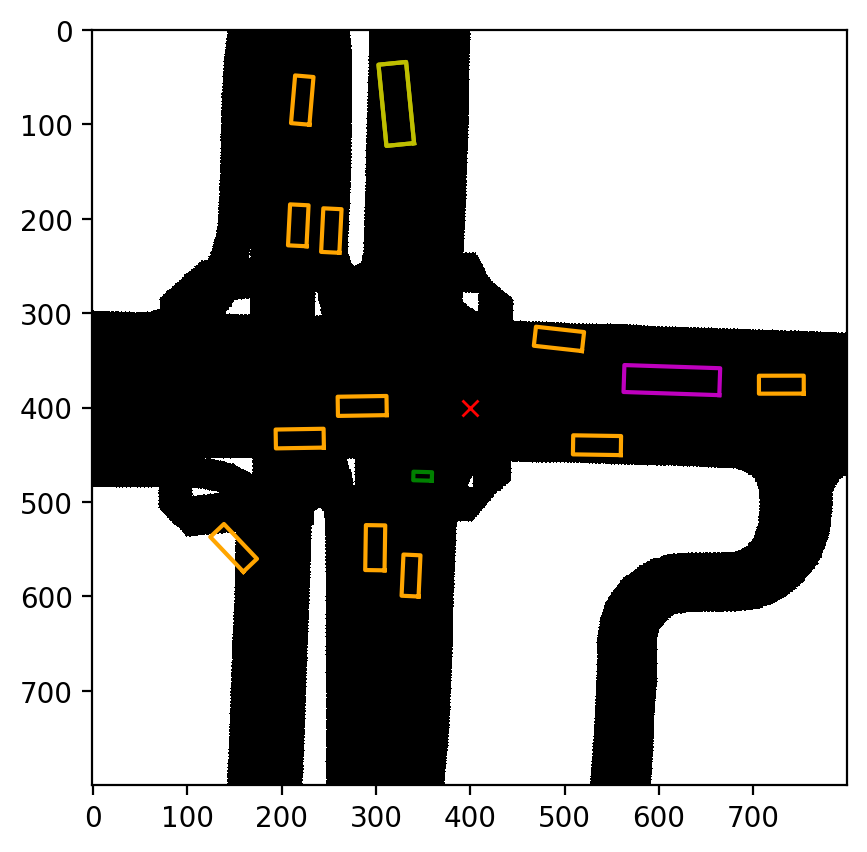

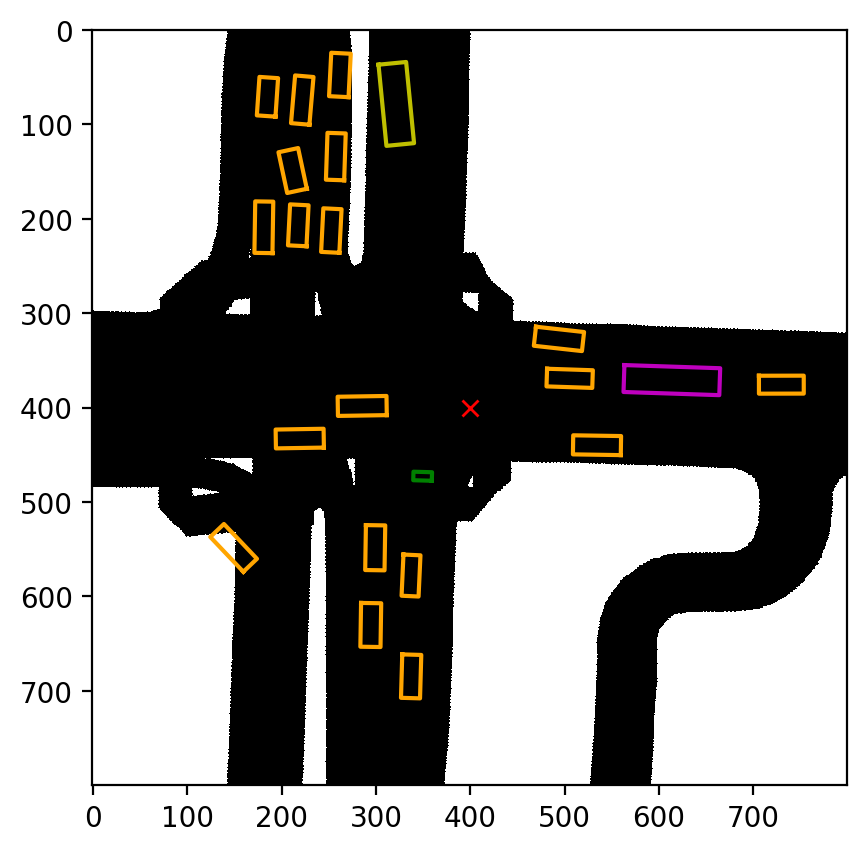

In [6]:
sample, target, road_image, extra = valloader.next()
sample = torch.stack(sample)
sample = sample.numpy().transpose(3, 4, 0, 1, 2).reshape(256, 306, -1)
sample = cv2.resize(sample, (256, 256))
sample = sample.reshape(256, 256, batchsize, 6, 3).transpose(2, 3, 4, 0, 1)
sample = torch.Tensor(sample).to(device)
t = []
for i in range(len(target)):
    tmp = []
    for j in range(len(target[i]['bounding_box'])):
        a, b, c, d, f= convert([800, 800], target[i]['bounding_box'][j].numpy())
        e = int(target[i]['category'][j])
        tmp.extend([e, a, b, c, d, f])
    t.append(convert_bbox2labels(tmp).transpose(2, 0, 1))
labels = torch.Tensor(np.array(t)).float().to(device)
# pred = model(sample).detach()
pred = labels.detach()
pred = pred.squeeze(dim=0) 
pred = pred.permute((1,2,0))

res = labels2bbox(pred)

bbox = []
cls = []
for i in res:
    tmp = []
    p1, p2, p4, p3 = get_rotated_rec(i[1], i[2], i[3], i[4], i[5])
    tmp.append(p1)
    tmp.append(p2)
    tmp.append(p3)
    tmp.append(p4) 
    
    bbox.append(list(np.array(tmp).T))
    cls.append(i[0])

fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(np.array(bbox)):
    draw_box(ax, torch.Tensor(bb*80-40), color=color_list[int(cls[i])])

fig, ax = plt.subplots()
color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
ax.imshow(road_image[0], cmap ='binary');
# The ego car position
ax.plot(400, 400, 'x', color="red")
for i, bb in enumerate(target[0]['bounding_box']):
    draw_box(ax, bb, color=color_list[target[0]['category'][i]]) 
    